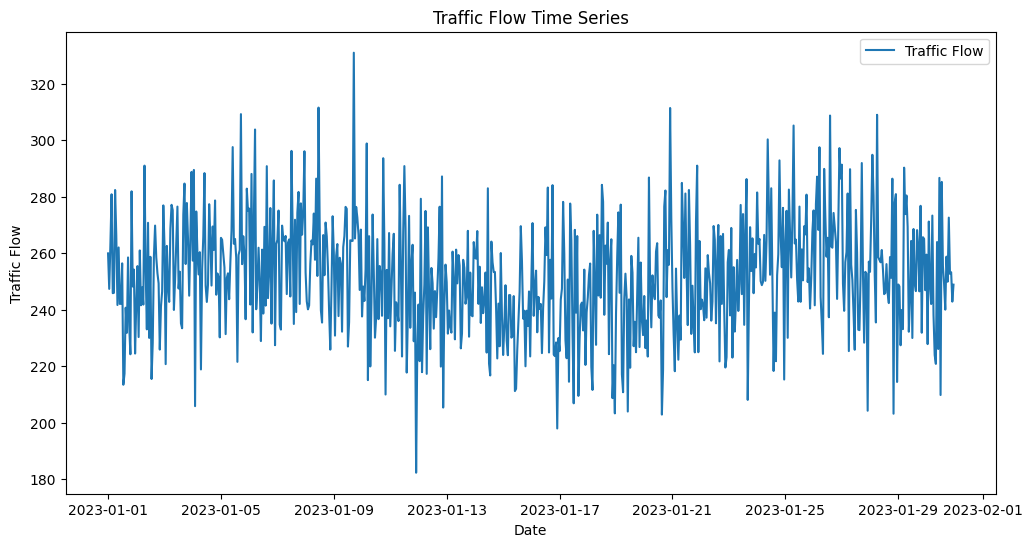

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0734 - val_loss: 0.0253
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - val_loss: 0.0197
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - val_loss: 0.0199
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - val_loss: 0.0199
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0224 - val_loss: 0.0205
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - val_loss: 0.0202
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - val_loss: 0.0198
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - val_loss: 0.0195
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216 - val_loss: 0.0194
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - val_loss: 0.0194
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
LSTM RMSE: 20.60937495332752
GRU RMSE: 20.844115406154344


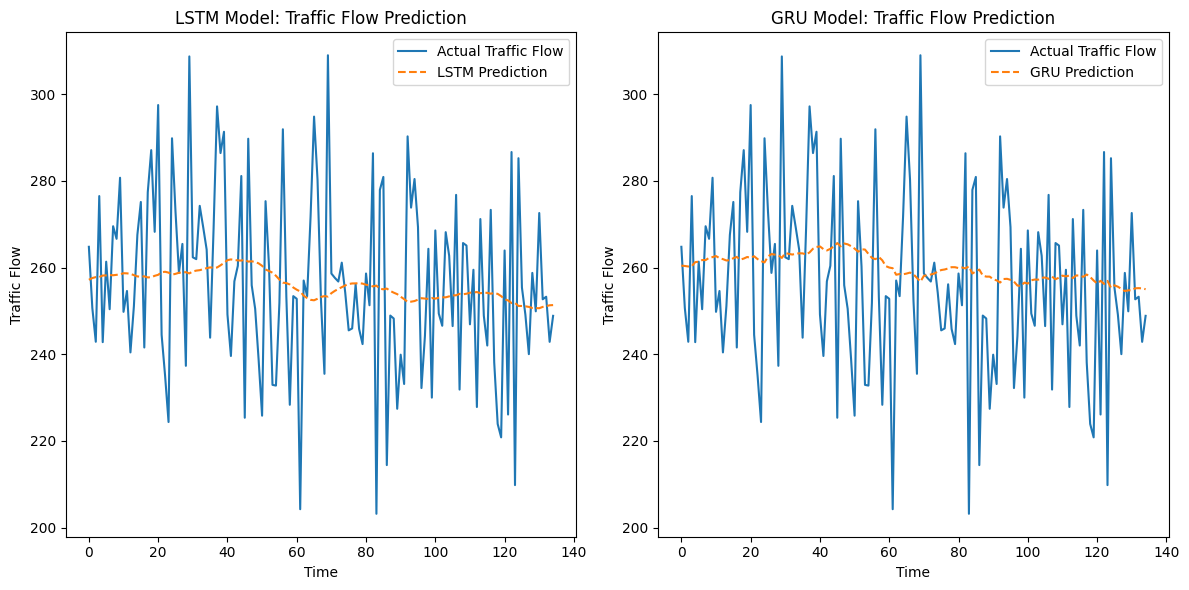

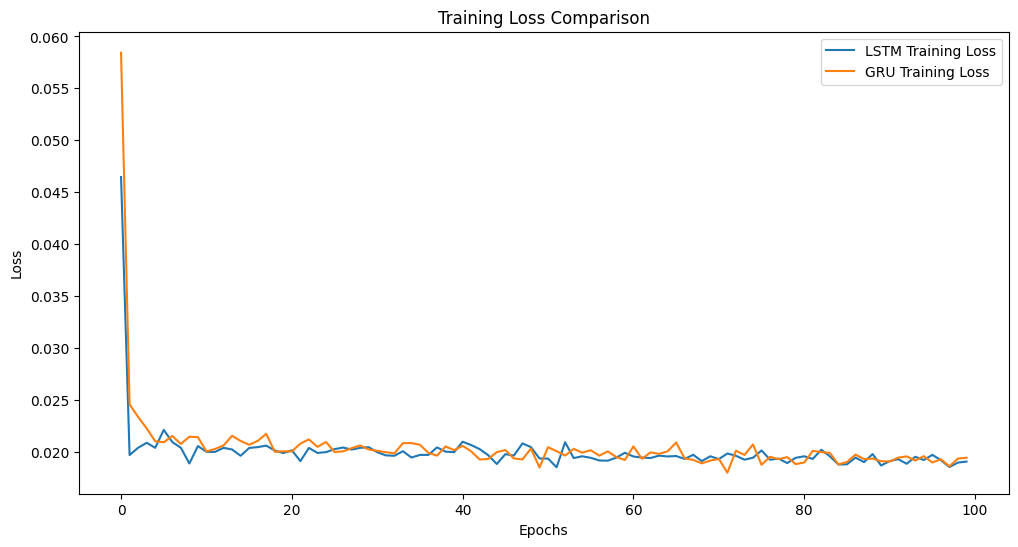

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Load dataset
data = pd.read_csv('traffic_flow.csv', parse_dates=['timestamp'], index_col='timestamp')

# Visualize the dataset
plt.figure(figsize=(12,6))
plt.plot(data.index, data['traffic_flow'], label="Traffic Flow")
plt.xlabel('Date')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow Time Series')
plt.legend()
plt.show()

# Step 1: Preprocessing the Data
scaler = MinMaxScaler(feature_range=(0, 1))
traffic_flow_scaled = scaler.fit_transform(data[['traffic_flow']])

# Create sequences of data for LSTM/GRU
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length, 0])
        labels.append(data[i+seq_length, 0])
    return np.array(sequences), np.array(labels)

# Define sequence length (number of previous time steps to predict the next step)
seq_length = 48  # E.g., using the past 48 hours to predict the next hour

X, y = create_sequences(traffic_flow_scaled, seq_length)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be suitable for LSTM/GRU (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 2: Model Development

# LSTM Model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# GRU Model
def create_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize models
lstm_model = create_lstm_model()
gru_model = create_gru_model()

# Step 3: Model Training
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Step 4: Model Evaluation
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Inverse scaling of predictions and actual values
lstm_pred = scaler.inverse_transform(lstm_pred)
gru_pred = scaler.inverse_transform(gru_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, lstm_pred))
gru_rmse = np.sqrt(mean_squared_error(y_test_rescaled, gru_pred))

print(f'LSTM RMSE: {lstm_rmse}')
print(f'GRU RMSE: {gru_rmse}')

# Step 5: Visualization
# Plot Predictions vs Actual for LSTM and GRU
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(y_test_rescaled, label="Actual Traffic Flow")
plt.plot(lstm_pred, label="LSTM Prediction", linestyle='--')
plt.title('LSTM Model: Traffic Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_rescaled, label="Actual Traffic Flow")
plt.plot(gru_pred, label="GRU Prediction", linestyle='--')
plt.title('GRU Model: Traffic Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Training Loss
plt.figure(figsize=(12,6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


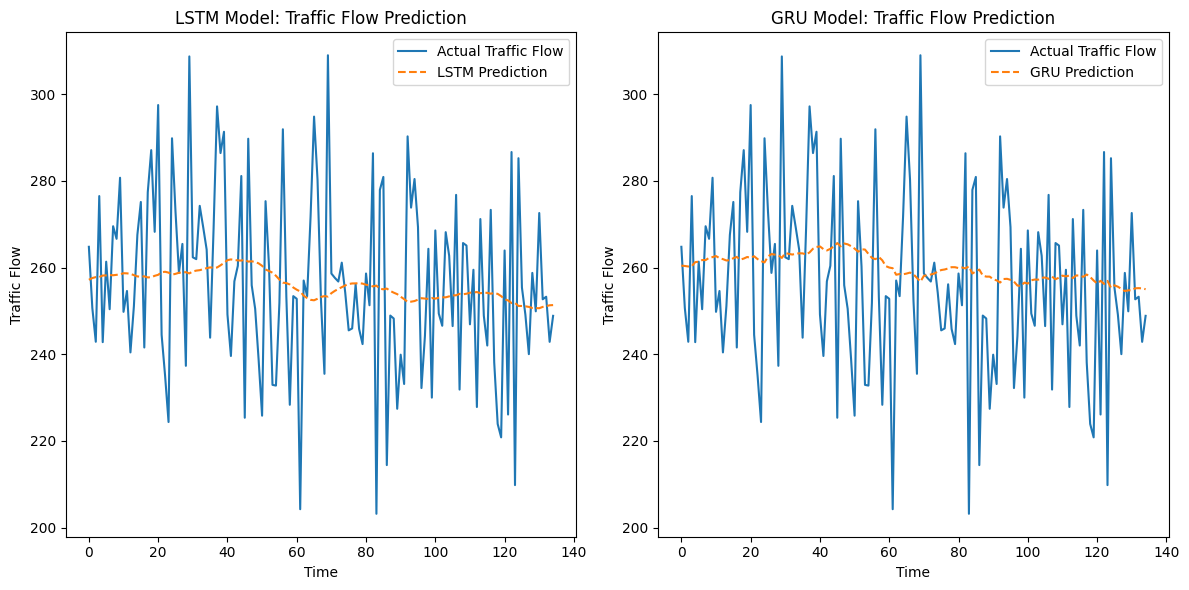

In [ ]:
# Plot Predictions vs Actual for LSTM and GRU
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(y_test_rescaled, label="Actual Traffic Flow")
plt.plot(lstm_pred, label="LSTM Prediction", linestyle='--')
plt.title('LSTM Model: Traffic Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_rescaled, label="Actual Traffic Flow")
plt.plot(gru_pred, label="GRU Prediction", linestyle='--')
plt.title('GRU Model: Traffic Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()

plt.tight_layout()
plt.show()

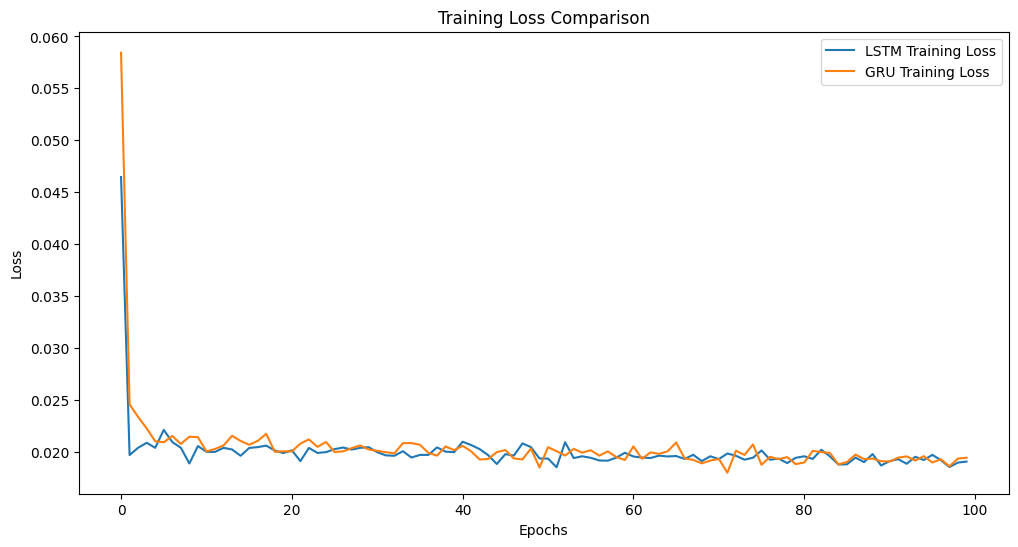

In [ ]:
# Plot Training Loss
plt.figure(figsize=(12,6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()